# Assignment 1

**DS: 207 Introduction to Natural Language Processing**

**Due (Feb 6, 16:59 PM)**

Development & Design: Debarpan Bhattacharya & Nicy Scaria.

Testing: Kinshuk Vasisht

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The goal of this assignment is introduce the basics of text processing, by building a few text classifiers, and learning to represent words.

You'll have to add your code wherever you see the comment `# ADD YOUR CODE HERE`. Please make a copy of this assignment, and you can use Google Colab notebooks to work on this. Later, you can download this notebook as a python file and submit it as per the following instructions.

## Submission Instructions:

1. In the notebook, a few example codes are provided, whereas a few are kept blank for you to fill them up.
2. The evaluation will be based on the results obtained by functions impleted by you. Do not change the print statements having `EVALUATION` as they are used for auto-evaluation.
3. **Submission file(s)**:
  
  * Save this `.ipynb` to your drive, complete the required code blocks and run the notebook.
  * After completing this assignment, download the notebook as`.py`. Name it as `SAPname_SRno_assignment1.py`, where `SAPname` refers to your name as per SAP record, and `SRno` refers to the last 5 digits of your IISc SR number. For example, IISc student with SAP name Twyla Linda (SR no - 04-03-00-10-22-20-1-15329) would name it as `Twyla_Linda_15329_assignment1.py`.
  *   The files associated with the Word2Vec training, i.e., the `model.pt`, `vocab.pt`, `word_embeddings.npy` and `loss.json`, will be downloaded and saved in a folder with the name `SAPname_SRno`. Zip this folder along with the `.py` file, save it as `SAPname_SRno_assigment1` and upload on MS Teams. The zip folder should contain: (1) `SAPname_SRno_assignment1.py`, (2) a subfolder called `SAPname_SRno` which will contain `model.pt`, `vocab.pt` , `word_embeddings.npy` and `loss.json`.


Because submissions are auto-graded, please ensure that the naming of the files is consistent with the instructions.

## Part I Text Classification (TA: Debarpan Bhattacharya)

**Dataset**:

We will dive into a basic text-based sentiment classification task. The dataset consists of sentences with two different kinds of sentiments- `positive`, and `negative` sentiments. Following are a set of examples,

* **`positive`**: *I really like your new haircut!*
* **`negative`**: *Your new haircut is awful!*

The Dataset has a training set (`train_data.csv`- provided), a validation set (`val_data.csv`- provided) and a blind test set (`test_data.csv`- not provided). The notebook uses a `test_data.csv` file, but it is just a duplicate of `val_data.csv`, and the blind `test_data.csv` will replace it while grading your solutions.

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.


### Download the dataset required for the assignment

In [2]:
import random
random.seed(42)

In [3]:
# download train data
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv"

# download validation data
!wget -O val_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv"

# download test data
!wget -O test_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv"

--2024-02-05 18:40:23--  https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv
Resolving docs.google.com (docs.google.com)... 142.250.99.138, 142.250.99.113, 142.250.99.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘train_data.csv’

train_data.csv          [              <=>   ]  15.12M  5.67MB/s    in 2.7s    

2024-02-05 18:40:27 (5.67 MB/s) - ‘train_data.csv’ saved [15851033]

--2024-02-05 18:40:27--  https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv
Resolving docs.google.com (docs.google.com)... 142.250.99.138, 142.250.99.113, 142.250.99.101, ...
Connecting to docs.google.com (docs.google.com)|142.250.99.138|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Savin

In [4]:
#@title Read data
import numpy as np
import pandas as pd

df = pd.read_csv('train_data.csv')
df_val = pd.read_csv('val_data.csv')

# Note that we will change the test file
# when we grade assignments  ...
# For now it is the same as the validation set
df_test = pd.read_csv('test_data.csv')

df.head()

,review,sentiment
0,I've watched this documentary twice - and alth...,positive
1,This is probably the worst movie I've seen in ...,negative
2,Superb story of a dedicated young teacher who ...,positive
3,<br /><br />Spoilers<br /><br />I'm going to b...,negative
4,"What can be said, really... ""The Tenant"" is a ...",positive


In [5]:
#@title Prepare training, validation and test data.

X_train, y_train = df.review.values.tolist(), df.sentiment.values.tolist()
X_val, y_val = df_val.review.values.tolist(), df_val.sentiment.values.tolist()
X_test, y_test = df_test.review.values.tolist(), df_test.sentiment.values.tolist()

labels = ['negative', 'positive']

# converting the sentiment labels into labels
# class 0 for negagtive, and class 1 for positive
y_train = [labels.index(i) for i in y_train]
y_val = [labels.index(i) for i in y_val]
y_test = [labels.index(i) for i in y_test]

In [158]:
import string
p={}
n={}
for i in range(0,len(X_train)):

  x_split = [word.rstrip(string.punctuation) for word in X_train[i].split(' ')]

  if(y_train[i] ==1):
    for word in x_split:
      p[word]=p.get(word,0)+1
  else:
    for word in x_split:
      n[word]=n.get(word,0)+1

In [249]:
word_ratios = {word: n.get(word, 0) / p.get(word, 1) for word in n}

# print("Word Ratios:", word_ratios)
sorted_word_ratios = dict(sorted(word_ratios.items(), key=lambda item: item[1], reverse=True))

# print("Sorted Word Ratios:", sorted_word_ratios)
filtered_negative_word_ratios = {word: ratio for word, ratio in sorted_word_ratios.items() if n.get(word, 0) > 200 }

# print("Filtered Word Ratios (>300 in dict n):", filtered_negative_word_ratios)

word_ratios = {word: p.get(word, 0) / n.get(word, 1) for word in p}

# print("Word Ratios:", word_ratios)
sorted_word_ratios = dict(sorted(word_ratios.items(), key=lambda item: item[1], reverse=True))

# print("Sorted Word Ratios:", sorted_word_ratios)
filtered_positive_word_ratios = {word: ratio for word, ratio in sorted_word_ratios.items() if p.get(word, 0) > 200 }

# print("Filtered Word Ratios (>300 in dict n):", filtered_positive_word_ratios)



In [250]:
# positive_words=list(filtered_positive_word_ratios.keys())
# negative_words=list(filtered_negative_word_ratios.keys())

positive_words=list(filtered_positive_word_ratios.keys())
negative_words=list(filtered_negative_word_ratios.keys())
N=20
very_good_words=positive_words[:N]
good_words=positive_words[N:2*N]
bad_words=negative_words[N:2*N]
very_bad_words=negative_words[:N]
# print(good_words)

#### Approach 1: Rule based classification

The rule-based classification works using a few hand-crafted rules. In sentiment classification, few words are associated with positive sentiment and few others with negative sentiment. Let's attempt to build a classifier that predicts the sentiment of the reviews based on such words.

Let's first write a few rules to extract important features about the input movie review. As an example, we provide a function that counts the number of `good` and `bad` words in the input.

Below, you can see a sample rule-based classification system. Later, you will be building one yourself.

In [251]:
def sample_extract_features(X):
    """
    Extracts features from a text input.

    Args:
        X (string): Text input.

    Returns:
        dictionary: features extracted from X.
    """

    features = {}
    X_split = X.split(' ')

    # Count the number of "good words" and "bad words" in the text
    good_words = ['love', 'good', 'brilliant', 'fantastic', 'amazing', 'great']
    bad_words = ['hate', 'bad', 'horrible', 'awful', 'terrible', 'mess', 'frustating', 'frustatingly']

    features['good_word_count'], features['bad_word_count'] = 0, 0
    for x in X_split:
        if x in good_words:
            features['good_word_count'] = features.get('good_word_count', 0) + 1
        if x in bad_words:
            features['bad_word_count'] = features.get('bad_word_count', 0) + 1

    # The "bias" value can be set to one, to allow us to assign a "default" score to the text
    features['bias'] = 1
    return features

In [252]:
def sample_predict(X, feature_weights):
    """
    Classifies the sentiment of a text input.

    Args:
        X (string): Text input.
        feature_weights: weightage of different features.

    Returns:
        int: binary sentiment represented by 0/1.
    """

    score = 0

    # Here we just multiply the feature value
    # with its corresponding weight and aggregate
    for feat_name, feat_value in sample_extract_features(X).items():
        score = score + feat_value * feature_weights[feat_name]

    # the prediction is based on whether the aggregated score is above 0 or not
    if score > 0:
        return 1
    else:
        return 0

In [253]:
def get_sample_features_weights():
  """
    To obtain feature weightage for different features.

    Args:
        None here.

    Returns:
        dictionary: feature names and their weightage.
    """
  # Based on the selected features, you can manually assign them weights
  feature_weights = {'good_word_count': 1.0, 'bad_word_count': -1.0, 'bias': 0.5}
  return feature_weights

In [254]:
#@title Computing the accuracy of the system

def calculate_accuracy(Y_true, Y_pred):
    """
    Calculates accuracy of predictions given the ground truth.

    Args:
        Y_true (list): Ground truth labels.
        Y_pred (list): Predictions.

    Returns:
        float: Prediction accuracy in range [0.0-100.0].
    """
    correct = 0.0
    total = len(Y_true)

    # verify if we have the same number of predictions as labels
    assert len(Y_true) == len(Y_pred)

    # count the number of correct predictions
    for y_true, y_pred in zip(Y_true, Y_pred):
        if y_true == y_pred:
            correct += 1.0

    if total > 0:
        return 100. * correct / total

    # return 0 if there the total number of examples are zero
    return 0.0

In [255]:
#@title Putting the sample rule-based classifier together

# get the sample weights
sample_feature_weights = get_sample_features_weights()

predictions = []

# for each test example, make a prediction
for input_example in X_test:
    y = sample_predict(input_example, sample_feature_weights)
    predictions.append(y)

# compute and print the accuracy
print (calculate_accuracy(y_test, predictions))

60.5


As you can observe here, the model achieves about 60% accuracy (note that the performance of a random classifier would be close to 50%).

### Build your own rule-based classifier (10 marks)

Your have to write your own `extract_features`, `get_feature_weights` and `predict` functions for your rule-based classifier.

In [256]:
def extract_features(X):

    features = {}
    features['bias'] = 1
    # ADD YOUR CODE HERE
    X_split = [word.rstrip(string.punctuation) for word in X.split(' ')]
    X_split=[element.lower() for element in X_split]


    features['very_good_words']=0
    features['good_words']=0
    features['bad_words']=0
    features['very_bad_words']=0

    for x in X_split:
      if x in good_words:
        features['good_words']=features.get('good_words',0)+1
      elif x in very_good_words:
          features['very_good_words']=features.get('very_good_words',0)+1
      elif x in bad_words:
        features['bad_words']=features.get('bad_words',0)+1
      elif x in very_bad_words:
          features['very_bad_words']=features.get('very_bad_words',0)+1
    return features

In [257]:
def get_feature_weights():

    feature_weights = {}
    feature_weights['bias'] = 0.5

    # ADD YOUR CODE HERE   (***Modified***)

    feature_weights['very_good_words']=1.8
    feature_weights['good_words']=0.7
    feature_weights['very_bad_words']=-2
    feature_weights['bad_words']=-1
    # please manually assign feature weights to the features you've extracted

    return feature_weights

In [258]:
def predict(X, feature_weights):
    """
    Classifies the sentiment of a text input.

    Args:
        X (string): Text input.
        feature_weights: weightage of different features.

    Returns:
        int: binary sentiment represented by 0/1.
    """

    # ADD YOUR CODE HERE
    score=0
    for feat_name, feat_value in extract_features(X).items():

      score = score + feat_value * feature_weights[feat_name]


    if score >= 0:
        return 1
    else:
        return 0
    return 1.0

In [259]:
#@title Evaluating your rule-based classifier

## Please do not change anything in this code block.

feature_weights = get_feature_weights()

predictions = []

for input_example in X_test:
    y = predict(input_example, feature_weights)
    predictions.append(y)

print (f"EVALUATION of rule-based classifier is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of rule-based classifier is: 79.45


You will be evaluated based on the performance of your rule-based classifier. Please note that the sample rule-based classifier achieves about 60% accuracy. Anything below 60% will not yield any points.

***Please do not change the evaluation code in the block above, as it would be used to grade your classifier***.

Below, we will directly learn the feature weights, rather than manually assigning those ourselves as manual assignment can be error-prone and labor intensive.

In [260]:
#@title Learning the weights of extracted features using logistic regression.

from sklearn.linear_model import LogisticRegression

def get_sample_learnable_weights(X_data, Y_data, sample_extract_features):
    """
    Learn feature weights using the training data.

    Args:
        X_data (list of strings): All the text data points in training data.
        Y_data (list of int): Ground truth labels for text data points in X_data.
        sample_extract_features: A Function that extracts features from text sample.
                                 The sample_extract_features function should be of the
                                 same format as sample_extract_features(X) function
                                 implemented above.

        Returns:
            dictionary: feature names and their learned weights.
    """
    # training a logistic regression model for classification using
    # the features obtained by sample_extract_features(X) function.

    # get all feature names
    feature_names = list(sample_extract_features(X_data[0]).keys())

    # Below code snippet accumulates features extracted from all the
    # text data points in X_data.
    all_features = []
    # iterate over all text data points in X_data.
    for input_example in X_data:
      feature = [] # to store features extracted from input_example.
      feat_dict = sample_extract_features(input_example)
      # iterate over different feature names and store the corresonding values.
      for name in feature_names:
        feature.append(feat_dict[name])
      all_features.append(feature) # append features obtained from input_example to all_features.

    # Below, we show how to fit a logistic regression (LR) model using the features and the target labels.
    # We use Sklearn's 'LogisticRegression' to do this. While initiating, 'fit_intercept' is set False,
    # because 'bias' is already included in the extracted feature (see sample_extract_features() implementation).
    # Also, random state is set to 42 to avoid different initialization of the model while running the codebook
    # multiple times.
    clf = LogisticRegression(fit_intercept=False, random_state=42).fit(all_features, Y_data)

    # As training a logistic regression model assigns weights to each of the features (refer class notes),
    # these weights are learnable and we will use them as learned feature weights.

    # extract feature weights.
    coffs = clf.coef_[0]

    # convert to dictionary
    coffs_dict = {feature_names[i]: coffs[i] for i in range(len(feature_names))}

    return coffs_dict

In [261]:
#@title Putting the sample rule-based classifier with learnable weights together

# get the sample weights
sample_feature_weights_lr = get_sample_learnable_weights(X_train, y_train, sample_extract_features)

predictions = []

for input_example in X_test:
    y = sample_predict(input_example, sample_feature_weights_lr)
    predictions.append(y)

print (calculate_accuracy(y_test, predictions))

63.775


As you can observe here, the model achieves about 63% accuracy (note that the performance of a random classifier would be close to 50%). Note that, the performance significantly improves by making the weights learnable as compared to the manual weights.

## How does learnable weights-based classifier work on the features you implemented (3 marks)

Your don't have to write anything here except simply running the below kernel.
Depending upon the quality of your features, your classifier performance will vary.

In [262]:
#@title Evaluating your rule-based classifier with learnable weights.

## Please do not change anything in this code block.
feature_weights_lr = get_sample_learnable_weights(X_train, y_train, extract_features)

predictions = []

for input_example in X_test:
    y = predict(input_example, feature_weights_lr)
    predictions.append(y)

print (f"EVALUATION of rule-based classifier with learnable weights is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of rule-based classifier with learnable weights is: 79.775


In [263]:
# feature_weights_lr

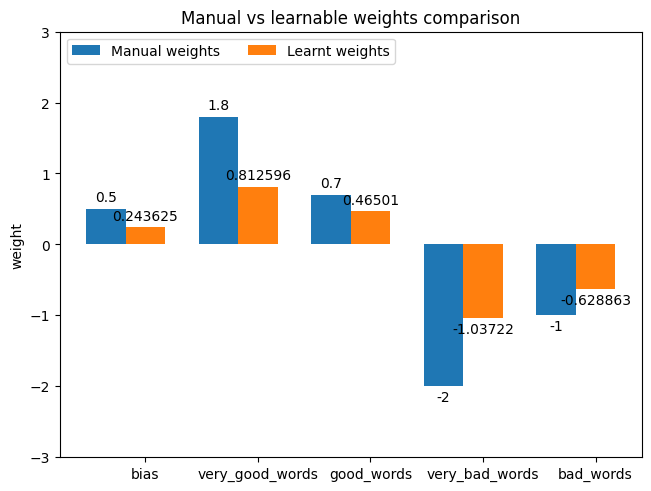

In [264]:
#@title Visualization and comparison between manual and learnable weights.

# visualize and compare the manual weights vs learnt weights.

import matplotlib.pyplot as plt
import numpy as np

feature_names = list(feature_weights.keys())
manual_weights = [feature_weights[name] for name in feature_names]
learnt_weights = [feature_weights_lr[name] for name in feature_names]
weights_dict = {
    'Manual weights': manual_weights,
    'Learnt weights': learnt_weights,
}

x = np.arange(len(feature_names))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in weights_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight')
ax.set_title('Manual vs learnable weights comparison')
ax.set_xticks(x + width, feature_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(-3, 3)

plt.savefig('manual_vs_learned_weights.png')
# Refer to the saved manual_vs_learned_weights.png to see how manual and learned weights compare.

### Approach 2: Bag-of-Words (BoW) (10 marks)

The BoW vector representations is based on the unordered counts of words piece of text (similar to a "bag" of words).

Let's attempt to build a classifier that tries to classify the reviews based on such vectors.

In [23]:
# implement your BoW classifier. In case the total number of words are very large,
# consider using top-k most frequent words (e.g. k=10,000) while creating BoW vectors.

# The below function finds out all words present in the corpus and assigns each word to
# an index.

def word_to_idx_BOW(X_data, K=10000):
    """
    Generates a set of word-index pairs after analyzing all words present in entire
    data corpus X_data.

    Args:
        X_data (list of strings): All the text data points in training data.
        K (int): The number of most frequent words to be considered.
                 In case (K-p)th to (K+q)th words in most frequent words order
                 have same frequency, you can choose p words randomly from those
                 (p+q) number of words.

        Returns:
            dictionary: words as keys and indices as values.
    """
    word_to_idx = {}
    # ADD YOUR CODE HERE


    #let us try to implement the naive classifier which does not remove stopwords

    word_count={}
    for X in X_data:
      X_split=X.split(' ')
      for word in X_split:
        word_count[word]=word_count.get(word, 0) + 1
    sorted_words = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

    # Take the top 10,000 words
    top_words = sorted_words[:10000]

    # Create a word_to_idx dictionary
    word_to_idx = {word: idx for idx, (word, _) in enumerate(top_words)}

    return word_to_idx

# generate BoW feature for text input X.
def extract_features_BoW(X, word_to_idx):
    """
    Generates BoW feature for X using word_to_idx.

    Args:
        X (string): text input.
        word_to_idx (dictionary): word-index mapping with words as keys and
                                  indices as values.

        Returns:
            dictionary: features of X.
    """
    features = {}
    # ADD YOUR CODE HERE

    features={word:0 for word in word_to_idx}
    words=X.split(' ')

    for word in words:
      if word in word_to_idx:
        features[word]+=1

    return features

In [24]:
# checking the outputs of the above functions on a small set of examples

sample_data = [
    "When is the homework due ?",
    "When are the TAs' office hours ?",
    "How hard is the homework ?",
]
word_to_idx = word_to_idx_BOW(sample_data)
features = extract_features_BoW(sample_data[0], word_to_idx)
print(features)


{'the': 1, '?': 1, 'When': 1, 'is': 1, 'homework': 1, 'due': 1, 'are': 0, "TAs'": 0, 'office': 0, 'hours': 0, 'How': 0, 'hard': 0}


In [25]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [26]:
#@title Implement your feature weight learning for BoW classifier

def get_learnable_weights_BoW(X_data, Y_data, word_to_idx_BOW, extract_features_BoW):
    """
    Learning feature weights for BoW features, using training data.

    Args:
        X_data (list of strings): All the text data points in training data.
        Y_data (list of int): Ground truth labels for text data points in X_data.
        word_to_idx_BOW: A Function that looks at all the words in data corpus X_data
                         and returns word-index mapping. You had to implement
                         word_to_idx_BOW() funtion above.
        extract_features_BoW: A Function that extracts BoW features from text sample.
                              The extract_features_BoW() function had to be implemented
                              by you above.

        Returns:
            dictionary: feature names and their learned weights.
    """

    # ADD YOUR CODE HERE

    # Now i will try to implement the logistic regression algorithm here to learn the feature weights
    word_to_idx=word_to_idx_BOW(X_data)

    # Extract BoW features for each training sample
    X_bow = np.array([list(extract_features_BoW(X, word_to_idx).values()) for X in X_data])

    # print(X_bow)
    # Initialize logistic regression model
    logistic_model = LogisticRegression(max_iter=1000)

    # Train the model
    logistic_model.fit(X_bow, Y_data)


    feature_names = list(word_to_idx.keys())
    coffs_dict = {feature_names[i]: logistic_model.coef_[0][i] for i in range(len(feature_names))}


    return coffs_dict

In [27]:
#@title Evaluating your BoW classifier

def predict(X, feature_weights):
    """
    Classifies the sentiment of a text input.

    Args:
        X (string): Text input.
        feature_weights: weightage of different features.

    Returns:
        int: binary sentiment represented by 0/1.
    """
    # ADD YOUR CODE HERE

    words = X.split()
    score = 0

    for word in words:
        if word in feature_weights:
            score += feature_weights[word]

    # Apply sigmoid activation
    # probability = sigmoid(score)

    # Threshold the probability
    if score>0:
        return 1
    else:
        return 0



    return 1.0

# get the sample weights
BoW_feature_weights_lr = get_learnable_weights_BoW(X_train, y_train, word_to_idx_BOW, extract_features_BoW)
# print(BoW_feature_weights_lr)
predictions = []

for input_example in X_test:
    y = predict(input_example, BoW_feature_weights_lr)
    predictions.append(y)

print (f"EVALUATION of BoW classifier is: {calculate_accuracy(y_test, predictions)}")

EVALUATION of BoW classifier is: 85.45


## Finding most positive and most negative words (2 Marks)

Based on the magnitude of weights corresponding to different words, write down code to find the 5 most positive words and 5 most negative words.

In [28]:
most_positive_words = []
most_negative_words = []

## WRITE CODE HERE TO POPULATE THESE LISTS
most_positive_words=sorted(BoW_feature_weights_lr, key=BoW_feature_weights_lr.get, reverse=True)[:5]
most_negative_words = sorted(BoW_feature_weights_lr, key=BoW_feature_weights_lr.get)[:5]

## most_postive_words and most_negative_words should be list of strings

assert (len(most_positive_words) == 5)
assert (len(most_negative_words) == 5)

print("EVALUATION five most positive words: " + " ".join(most_positive_words))
print("EVALUATION five most negative words: " + " ".join(most_negative_words))

EVALUATION five most positive words: wonderfully subtitles subtle terrific favorite
EVALUATION five most negative words: waste poorly worst fails boring


## Part II Word2Vec (TA: Nicy Scaria)  (25 Marks)

Word2vec is one of the most popular techniques to learn word embeddings. The idea behind word2vec was that the meaning of a word is determined by the context in which it occurs. A word embedding is a learned representation for text where words that have the same meaning have a similar representation.

**Word2vec** model has 2 architectures:

1. **Continuous bag of word (CBOW):**

    CBOW predicts the center word from the surrounding context words.

2. **Skip-gram:**

    Skip-gram predicts surrounding context words from the center word.

#### SkipGram from Scratch

In this exercise, you will code the skipgram model from scratch using the PyTorch library.

In [29]:
# Just added by me for the GPU utilization
import torch,gc
gc.collect()
torch.cuda.empty_cache()

In [30]:
!pip install -U portalocker
 #make sure you install the library and restart the session

In [31]:
torch.cuda.is_available() # added by me for my checking purposes

True

In [32]:
# importing the necessary libraries
import torch
from functools import partial
import torch.nn as nn
from torch.utils.data import DataLoader
from torchtext.data import to_map_style_dataset
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import WikiText2
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
# import torch.nn.functional as F #added by me
import os
import numpy as np
import json
import argparse

> **In the following code the add your hyperparameters for the network.**

In [85]:
# Initialization


"""choose your hyperparameter and see the difference in performance"""

# ADD YOUR CODE HERE

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please free to play with these hyperparameters to see the effects on the
# quality of generated embeddings


SKIPGRAM_N_WORDS = 4 # the length of the context on each side (k)

MIN_WORD_FREQUENCY = 40 # only words with a minimum word frequency considered
MAX_SEQUENCE_LENGTH = 250 # sentences with length more than this value truncated

EMBED_DIMENSION = 300 # dimension of the word2vec vectors

EMBED_MAX_NORM = 1

In [34]:
def get_english_tokenizer():
    """
    Documentation:
    https://pytorch.org/text/stable/_modules/torchtext/data/utils.html#get_tokenizer
    """
    tokenizer = get_tokenizer("basic_english", language="en")
    return tokenizer

def get_data_iterator(ds_name, ds_type, data_dir):
    """
    input dataset used:
    https://paperswithcode.com/dataset/wikitext-2
    This is directly imported from PyTorch.
    """
    data_iter = WikiText2(root=data_dir, split=(ds_type))
    data_iter = to_map_style_dataset(data_iter)
    return data_iter

def build_vocab(data_iter, tokenizer):
    """Builds vocabulary from iterator"""

    vocab = build_vocab_from_iterator(
        map(tokenizer, data_iter),
        specials=["<unk>"], #adding special tokens to the vocabulary
        min_freq=MIN_WORD_FREQUENCY,
    )
    vocab.set_default_index(vocab["<unk>"])
    return vocab


def collate_skipgram(batch, text_pipeline):
    """
    This function prepares data for training the skipgram model.
    It generates pairs of center and context words from the batch of text.

    batch: A batch of text data
    text_pipeline: A pipeline function that processes text into tokens
    (batch_input, batch_output) -> (center word, context words)
    """
    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        text_tokens_ids = text_pipeline(text)

        # Skip texts shorter than the required window size
        if len(text_tokens_ids) < SKIPGRAM_N_WORDS * 2 + 1:
            continue

        # Truncate texts to a maximum sequence length if specified
        if MAX_SEQUENCE_LENGTH:
            text_tokens_ids = text_tokens_ids[:MAX_SEQUENCE_LENGTH]

        # Create training pairs for each word in the text
        for idx in range(len(text_tokens_ids) - SKIPGRAM_N_WORDS * 2):
            token_id_sequence = text_tokens_ids[idx : (idx + SKIPGRAM_N_WORDS * 2 + 1)]
            input_ = token_id_sequence.pop(SKIPGRAM_N_WORDS)
            outputs = token_id_sequence

            # Add each context word with the center word to the output lists
            for output in outputs:
                batch_input.append(input_)
                batch_output.append(output)

    # Convert lists to PyTorch tensors
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)

    return batch_input, batch_output


def get_dataloader_and_vocab(
    model_name, ds_name, ds_type, data_dir, batch_size, shuffle, vocab=None
    ):
    """
    Prepares a DataLoader and builds a vocabulary for the dataset.
    model_name: Name of the model to be used
    ds_name: Name of the dataset
    ds_type: Type of the dataset (e.g., train, test)
    data_dir: Directory where the dataset is stored
    batch_size: Size of each batch
    vocab: An existing vocabulary, if available

    """

    data_iter = get_data_iterator(ds_name, ds_type, data_dir)
    tokenizer = get_english_tokenizer()

    if not vocab:
        vocab = build_vocab(data_iter, tokenizer)

    text_pipeline = lambda x: vocab(tokenizer(x))

    collate_fn = collate_skipgram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader

    """
    dataloader = DataLoader(
        data_iter,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )

    return dataloader, vocab


### Initialize the SkipGram Model

 **Complete the `initialization` and `forward` function in the following  SkipGram_Model class**

In [35]:
class SkipGram_Model(nn.Module):
    """
    Implementation of Skip-Gram model described in paper:
    https://arxiv.org/abs/1301.3781
    """
    def __init__(self, vocab_size: int):
        super(SkipGram_Model, self).__init__()
        self.embeddings=nn.Embedding(num_embeddings=vocab_size,embedding_dim=EMBED_DIMENSION,max_norm=EMBED_MAX_NORM)
        self.linear=nn.Linear(EMBED_DIMENSION,vocab_size)


    def forward(self, inputs_):
        """define forward function"""
        # ADD YOUR CODE HERE
        x=self.embeddings(inputs_)

        x=self.linear(x)
        # return the output of your final layer to find the minimize the loss

        return x

    def get_word_embedding(self):
        """ return the associated word embeddings for center words """

        # ADD YOUR CODE HERE
        embeddings =list(model.parameters())[0]
        embeddings = embeddings.cpu().detach().numpy()
        norms = np.linalg.norm(embeddings, axis=1)
        norms = norms.reshape(-1, 1)
        embeddings = embeddings / (norms)


        return embeddings

> **The following is the Trainer class for the skip-gram model. Add your code for the `training` and `validation` loops.**

In [36]:
class Trainer:
    """Main class for model training"""

    # NOTE: you are free to add additional inputs/functions
    # to the trainer class to make training better
    # make sure to define and add it within the input
    # and initialization if you are using any additional inputs
    # for usage in the function

    def __init__(
        self,
        model,
        epochs,
        train_dataloader,
        val_dataloader,
        criterion,
        optimizer,
        lr_scheduler,
        device,
        model_dir,
        model_name,
    ):
        self.model = model
        self.epochs = epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.lr_scheduler=lr_scheduler
        self.device = device
        self.model_dir = model_dir
        self.model_name = model_name
        self.loss = {"train": [], "val": []}
        self.model.to(self.device)

    def train(self):
      for epoch in range(self.epochs):
        self._train_each_epoch(epoch)
        self._validate_each_epoch(epoch)
        print("Epoch: {}/{}".format(epoch + 1, self.epochs),"Train Loss={:.5f}, Val Loss={:.5f}".format(self.loss["train"][-1], self.loss["val"][-1]))

        self.lr_scheduler.step()

    def _train_each_epoch(self,epoch):
      self.model.train()  # sets the model to training mode
      running_loss=[]

      for i,batch_data in enumerate(self.train_dataloader,1):
        inputs=batch_data[0].to(self.device)
        labels=batch_data[1].to(self.device)

        self.optimizer.zero_grad()

        outputs=self.model(inputs) # forward pass of data
        loss=self.criterion(outputs,labels)
        loss.backward()
        self.optimizer.step()

        running_loss.append(loss.item())


      epoch_loss=np.mean(running_loss)

      self.loss["train"].append(epoch_loss)


    def _validate_each_epoch(self,epoch):

      self.model.eval() # set the model to evaluation mode
      running_loss=[]


      with torch.no_grad():  #No need to do the parameter updates in validation and testing time so
        for i,batch_data in enumerate(self.val_dataloader,1):
          inputs=batch_data[0].to(self.device)
          labels=batch_data[1].to(self.device)


          outputs=self.model(inputs)
          loss=self.criterion(outputs,labels)


          running_loss.append(loss.item())

      epoch_loss=np.mean(running_loss)

      self.loss["val"].append(epoch_loss)

    def save_model(self):
        """
        Save final model to directory

        """
        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model, model_path)

    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """
        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)

> **The following code block defines the various parameters and nomenclature for the training and saving of the skip-gram model. Add numerical values for the `specified hyperparameters`.**

In [37]:
# ADD YOUR CODE HERE
# CHANGE THE None VALUES TO YOUR DESIRED VALUES

model_name = 'skipgram'

dataset = 'WikiText2'
data_dir = './data/'
train_batch_size =96
val_batch_size =96
shuffle = True

learning_rate = 0.025   # mentioned in reference paper
epochs = 5

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

model_dir = 'ALOKAMGNANESWARASAI_22582'

> **The following code block is used to train and save the model. Add the code wherever required**

In [86]:
try:
    os.makedirs(model_dir)
except FileExistsError:
     pass

train_dataloader, vocab = get_dataloader_and_vocab(
    model_name=model_name,
    ds_name=dataset,
    ds_type="train",
    data_dir=data_dir,
    batch_size=train_batch_size,
    shuffle=shuffle,
    vocab=None,
)

val_dataloader, _ = get_dataloader_and_vocab(
    model_name=model_name,
    ds_name=dataset,
    ds_type="valid",
    data_dir=data_dir,
    batch_size=val_batch_size,
    shuffle=shuffle,
    vocab=vocab,
)

vocab_size = len(vocab.get_stoi())
print(f"Vocabulary size: {vocab_size}")

model_class = SkipGram_Model
model = model_class(vocab_size=vocab_size)

criterion = nn.CrossEntropyLoss()
model.to('cuda')  # delete this if you are not using cuda
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# added LAMBDA_LR scheduler
def lr_lambda(epoch, epochs):
    return (epochs - epoch) / epochs

lr_scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: lr_lambda(epoch, epochs))

trainer = Trainer(
    model=model,
    epochs=epochs,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=criterion,
    optimizer=optimizer,
    lr_scheduler=lr_scheduler,   # added the lambda LR scheduler
    device=device,
    model_dir=model_dir,
    model_name=model_name,
)

trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Vocabulary size: 4911
Epoch: 1/5 Train Loss=5.78712, Val Loss=5.62404
Epoch: 2/5 Train Loss=5.64159, Val Loss=5.57186
Epoch: 3/5 Train Loss=5.59591, Val Loss=5.54945
Epoch: 4/5 Train Loss=5.56482, Val Loss=5.52355
Epoch: 5/5 Train Loss=5.53247, Val Loss=5.51363
Training finished.
Model artifacts saved to folder: ALOKAMGNANESWARASAI_22582


### Let us analyze the performance of the model

You'll be evaluated on the quality of the word representations as judged by the word similarity test, and word analogy tests.


In [87]:
#@title Evaluation

import numpy as np
import pandas as pd
import torch
import sys
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [138]:
# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

folder = "ALOKAMGNANESWARASAI_22582"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = torch.load(f"{folder}/model.pt", map_location=device)
vocab = torch.load(f"{folder}/vocab.pt")

In [139]:
word_embeddings = torch.tensor(model.get_word_embedding())

# ADD YOUR CODE HERE
# change the directory name with your SAPname and SRno

# Save the embeddings to the folder
np.save('ALOKAMGNANESWARASAI_22582/word_embeddings.npy', word_embeddings)

Once the embeddings are trained, we can use a few words to evaluate some desirable properties of word representations.

For instance, whether similar words are indeed similar in the high-dimensional space?

In [140]:
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother**

In [141]:
from sklearn.metrics.pairwise import cosine_similarity


In [142]:
def get_word_similarity(words):
  """
  This function takes the words as input and outputs the word vectors
  corresponding to the words obtained from your word2vec model and the
  similarity of every word with each other.
  word2vec is the embedding matrix corresponding to the given words and
  this has to be returned as a numpy array to apply PCA on it whereas,
  w2v_similarity[i][j] should contain the similarity of word i with word j

  """
  # ADD YOUR CODE HERE
  vocabulary=list(vocab.get_itos())
  word2vec=[]
  indices = [vocabulary.index(word) if word in vocabulary else vocabulary.index('<unk>') for word in words]

  if indices:
    word2vec=word_embeddings[indices][:]

  w2v_similarity = cosine_similarity(word2vec, word2vec)




  # you'll have to compute the similarity matrix for the words given above

  return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

Let us visualize this similarity matrix. The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [143]:
pd.DataFrame(w2v_similarity, columns = words, index = words)

,king,queen,river,water,ocean,tree,plant,happy,glad,mother,daughter
king,1.000000,0.452347,0.215016,0.140877,-0.008646,0.069908,0.057037,0.173862,0.220864,0.350373,0.427482
queen,0.452347,1.000000,0.175008,0.117990,0.081514,0.034929,0.007428,0.107374,0.226878,0.443603,0.437016
river,0.215016,0.175008,1.000000,0.373693,0.323884,0.088440,0.076378,0.026575,0.105515,0.041697,0.032281
water,0.140877,0.117990,0.373693,1.000000,0.322251,0.167035,0.180113,-0.020982,0.117313,0.059132,0.062112
ocean,-0.008646,0.081514,0.323884,0.322251,1.000000,0.049637,0.104949,0.057700,0.084809,0.076830,-0.047806
tree,0.069908,0.034929,0.088440,0.167035,0.049637,1.000000,0.213132,0.156774,0.194348,0.153938,0.173365
plant,0.057037,0.007428,0.076378,0.180113,0.104949,0.213132,1.000000,0.032701,0.157910,0.017871,0.026428
happy,0.173862,0.107374,0.026575,-0.020982,0.057700,0.156774,0.032701,1.000000,0.131727,0.189966,0.102248
glad,0.220864,0.226878,0.105515,0.117313,0.084809,0.194348,0.157910,0.131727,1.000000,0.292748,0.292588
mother,0.350373,0.443603,0.041697,0.059132,0.076830,0.153938,0.017871,0.189966,0.292748,1.000000,0.664442


<Axes: >

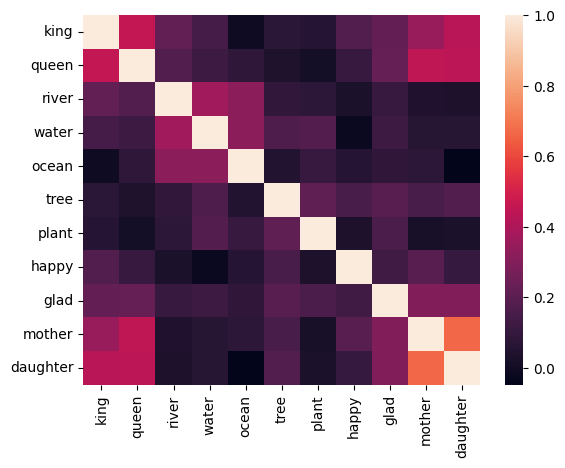

In [144]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [145]:
# Create a 2-dimensional PCA model of the word vectors using the scikit-learn PCA class
# n_components in PCA specifies the no.of dimensions
pca = PCA(n_components=2)

# Fit and transform the vectors using PCA model
reduced_w2v = pca.fit_transform(word2vec)

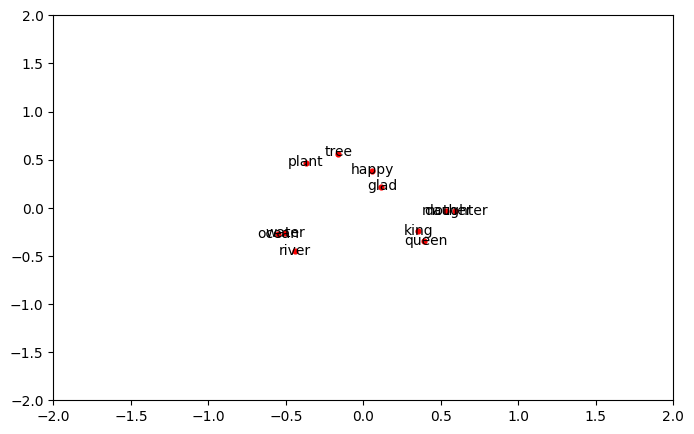

In [146]:
plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2,2])
plt.ylim([-2,2])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
offset = 0.5
for i in range(len(x)):
    label = words[i]
    xi, yi = x[i], y[i]
    plt.annotate(label, (xi, yi), xytext=(xi + offset, yi + offset),
                 textcoords='offset points', ha='center', va='center')

plt.savefig("word_similarity.png")

The 10 most similar word to the given word is calculated in the following code blocks

In [147]:
def get_top_similar(word: str, topN: int = 10):

    """
    This function calculates the topN words similar to the input word.
    If the word is not in vocabulary, then similarity is not calculated.
    If the word is in the vocabulary, then the dot product of the embedding
    matrix and the word vector is calculated. The topN words are selected.
    """
    word_id = vocab[word]
    if word_id == 0:
        print("Out of vocabulary word")
        return

    word_vec = model.get_word_embedding()[word_id]
    word_vec = np.reshape(word_vec, (len(word_vec), 1))

    dists = np.matmul(model.get_word_embedding(), word_vec).flatten()
    topN_ids = np.argsort(-dists)[1 : topN + 1]

    topN_dict = {}
    for sim_word_id in topN_ids:
        sim_word = vocab.lookup_token(sim_word_id)
        topN_dict[sim_word] = dists[sim_word_id]

    return topN_dict

In [148]:
for word, sim in get_top_similar("china").items():
   print("EVALUATION: most similar words to {}: {:.3f}".format(word, sim))

EVALUATION: most similar words to korea: 0.618
EVALUATION: most similar words to america: 0.482
EVALUATION: most similar words to brazil: 0.447
EVALUATION: most similar words to japan: 0.437
EVALUATION: most similar words to asia: 0.418
EVALUATION: most similar words to mozambique: 0.413
EVALUATION: most similar words to africa: 0.406
EVALUATION: most similar words to vietnam: 0.401
EVALUATION: most similar words to queensland: 0.401
EVALUATION: most similar words to regions: 0.398


### Analogy Tests

Analogy tests include questions of the format a:b::x:?, such tests are used to intrinsically evaluate the quality of word vectors.

Here's one example.

In [149]:
def get_analogy(word_1, word_2, word_3):

  """
  top 5 most analgous vector calculated correspond to a set similar to
  man: woman :: king: ? . This is calculated similar to the above case.

  """

  embeddings=model.get_word_embedding()
  emb1 = embeddings[vocab[word_1]]
  emb2 = embeddings[vocab[word_2]]
  emb3 = embeddings[vocab[word_3]]

  emb4 = emb1 - emb2 + emb3
  emb4_norm = np.linalg.norm(emb4)
  emb4 = emb4 / emb4_norm

  # compute dot products between 'emb4' and all word embeddings in the model.
  emb4 = np.reshape(emb4, (len(emb4), 1))
  dot_product = np.matmul(model.get_word_embedding(), emb4).flatten()

  top5 = np.argsort(-dot_product)[:5]

  return top5, dot_product

top5_analogy, dot_product = get_analogy('king', 'man', 'woman')

for word_id in top5_analogy:
    print("{}: {:.3f}".format(vocab.lookup_token(word_id), dot_product[word_id]))

king: 0.762
son: 0.472
woman: 0.456
cousin: 0.424
henry: 0.423


The model performance will be evaluated based on an analogy output for the top 5 words. The following code will used to evaluate the performance of the model on the analogies dataset. We will measure how often the correct answer is a part of the top 5 options.

In [150]:
# Downloading the file containing a few analogies.
# We will change the contents of this file while testing.

!wget -O analogies.txt "https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2"

--2024-02-05 19:43:46--  https://drive.google.com/uc?export=download&id=1jHx25dECegjtRKBB587nEfHiJesrH0g2
Resolving drive.google.com (drive.google.com)... 74.125.197.139, 74.125.197.138, 74.125.197.102, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download [following]
--2024-02-05 19:43:46--  https://drive.usercontent.google.com/download?id=1jHx25dECegjtRKBB587nEfHiJesrH0g2&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 286075 (279K) [application/octet-stream]
Saving to: ‘analogies.txt’

analogies.txt       100%[===================>] 279.37K  --.-KB/s

In [151]:
import random
random.seed(42)

def load_and_sample_analogies(file_path, sample_size=5000):
    with open(file_path, 'r') as file:
        analogies = []
        for line in file:
            # Split the line into words and ensure it has exactly 4 elements
            parts = line.strip().split()
            if len(parts) == 4:
                analogies.append(parts)

        # Sample analogies
        sampled_analogies = random.sample(analogies, min(sample_size, len(analogies)))
        return sampled_analogies

# Path to your text file
# NOTE: analogies used for grading could be slightly different
file_path = '/content/analogies.txt'

# Load and sample analogies
sampled_analogy_dataset = load_and_sample_analogies(file_path)

In [152]:
def get_word_id(word, vocab):
    """check for out of vocabulary items"""
    return vocab[word] if word in vocab else 0

def analogy_score(analogy_dataset):
    """
    The top5 analogous words calculated for each set of words for your
    implementation of word2vec and compared with an existing dataset to
    calculate if the expected word is in the first 5 predictions.
    """

    correct = 0
    total = 0

    for a, b, c, d in analogy_dataset:

        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        # Check if any word is out of vocabulary
        if 0 in [get_word_id(word, vocab) for word in [a, b, c, d]]:

            continue

        #finding the first five words that are analogous to the given set
        top5_analogy, dot_product = get_analogy(c, a, b)

        predicted_words = []

        for word_id in top5_analogy:
            word = vocab.lookup_token(word_id)
            predicted_words.append(word)

        if d in predicted_words:
            correct += 1

        total += 1
    # print("Total analogies are ",count)
    # print("Analogies that are correct are",correct)
    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5 = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test is", precision_at_5)

EVALUATION: Precision at 5 for the analogy test is 0.3148425787106447


#### Google's word2vec for comparison

In the following code blocks, the pretained word2vec developed by Google is used to analyze the quality of the embedding. The word2vec model can be downloaded from [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing).

In [61]:
!wget -O GoogleNews-vectors-negative300.bin "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"

--2024-02-05 18:54:35--  https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg
Resolving drive.google.com (drive.google.com)... 74.125.197.102, 74.125.197.139, 74.125.197.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.197.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download [following]
--2024-02-05 18:54:35--  https://drive.usercontent.google.com/download?id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.107.132, 2607:f8b0:400e:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.107.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2446 (2.4K) [text/html]
Saving to: ‘GoogleNews-vectors-negative300.bin’

GoogleNews-vectors- 100%[===================>]   2.39K  --.-

In [62]:
import bs4
import requests
import tqdm.auto as tqdm

def download_from_drive(drive_link, target_path):
    response = requests.get(drive_link, stream=True)
    response.raise_for_status()
    if 'html' in response.headers['Content-Type']:
        response = requests.get(drive_link)
        response.raise_for_status()
        page = bs4.BeautifulSoup(response.text, features="lxml")
        if form := page.find('form', id='download-form'):
            id   = form.select_one("input[name='id']")['value']
            uuid = form.select_one("input[name='uuid']")['value']
            data = { 'confirm': 't', 'export': 'download', 'id': id, 'uuid': uuid }
            response = requests.get(page.find('form')['action'], params=data, stream=True)
            response.raise_for_status()
    with open(target_path, 'wb+') as file:
        with tqdm.tqdm(
            total=int(response.headers['Content-Length']),
            unit='B', unit_scale=True, unit_divisor=1024
        ) as pbar:
            for chunk in response.iter_content(chunk_size=4096):
                file.write(chunk)
                pbar.update(len(chunk))
    print("Downloaded to", target_path)

drive_link = "https://drive.google.com/uc?export=download&id=12Oicgl5scdJLR7t8jbzKpW6o8QkYOylg"
target_path = "/content/GoogleNews-vectors-negative300.bin"

download_from_drive(drive_link, target_path)

  0%|          | 0.00/1.96k [00:00<?, ?B/s]

Downloaded to /content/GoogleNews-vectors-negative300.bin


In [63]:
import gensim

# Load Google news 300 vectors file
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

ValueError: invalid literal for int() with base 10: '<!DOCTYPE'

In [ ]:
# List of words to plot the embeddings
words = ['king', 'queen', 'river', 'water', 'ocean', 'tree', 'plant', 'happy', 'glad', 'mother', 'daughter']

> **Write a code to find the similarity of the each word in words with eachother using original word2vec**

In [ ]:
def get_word_similarity(words):
  """
  This function takes the words as input and outputs the word vectors
  corresponding to the words using Google's word2vec and the similarity of
  every word with eachother. word2vec is the embedding matrix for the words
  given above w2v_similarity[i][j] should contain the similarity of word i with j

  """
  # ADD YOUR CODE HERE

  # you'll have to compute the similarity matrix for the words given above

  return word2vec, w2v_similarity

word2vec, w2v_similarity = get_word_similarity(words)

The similarity of each word with other words in words is displayed as a pandas dataframe and as a heatmap

In [ ]:
pd.DataFrame(w2v_similarity, columns = words, index = words)

In [ ]:
sns.heatmap(pd.DataFrame(w2v_similarity, columns = words, index = words))

The size of the words embedding are reduced to to 2D and displayed as a scatterplot for analysis

In [ ]:
#PCA on word2vec embedding
pca = PCA(n_components=2)

reduced_w2v = pca.fit_transform(word2vec)

In [ ]:
#plotting reduced order embeddings in a 2-D space

plt.figure(figsize=(8,5))
plt.scatter(reduced_w2v[:,0],reduced_w2v[:,1], s = 12, color = 'red')
plt.xlim([-2.5,2.5])
plt.ylim([-2.5,2.5])
x, y = reduced_w2v[:,0] , reduced_w2v[:,1]
for i in range(len(x)):
    plt.annotate(words[i],xy=(x[i], y[i]),xytext=(x[i]+0.05,y[i]+0.05))

In [ ]:
model.most_similar('king')

Analogy test

In [ ]:
def analogy(x1, x2, y1): #defining analogy function
    result = model.most_similar(positive=[y1, x2], negative=[x1], topn = 5)
    return result

In [ ]:
analogy('man', 'king', 'woman')

In [ ]:
def analogy_score(analogy_dataset):

    """
    The top5 analogous words calculated for each set of words for Google's
    word2vec and compared with an existing dataset to calculate if the word
    is in the first 5 predictions.

    """
    correct = 0
    total = 0

    for a, b, c, d in analogy_dataset:
        # Convert words to lowercase
        a, b, c, d = a.lower(), b.lower(), c.lower(), d.lower()

        words_scores = analogy(a,b,c)

        predicted_words = [item[0] for item in words_scores]

        if d in predicted_words:
            correct += 1

        total += 1

    precision_at_5 = correct / total if total > 0 else 0
    return precision_at_5

precision_at_5_Google = analogy_score(sampled_analogy_dataset)
print("EVALUATION: Precision at 5 for the analogy test with Google skip-gram model is", precision_at_5_Google)

### Submission Instructions

Mentioned at the top of the notebook.

In [66]:
# !cp -r "/content/ALOKAMGNANESWARASAI_22582" "/content/drive/MyDrive/Colab Notebooks/ALOKAMGNANESWARASAI_22582"
